# Assignment #2

# In This assignment you are asked to read a data which include 48505 articles (Documents). Then fint the most similar documents using Locality Sensitive Hashing. Follow the lecture covering this topic step by step.

## 1. Data is available in Json format and you need to read it. 'https://www.ux.uis.no/~vsetty/data/assignment2_aricles.json' (5 points)
## 2. Shingle the documents (10 points)
### Tips:
* Use string package to cleanup the articles e.g, str.maketrans('', '', string.
punctuation)
* It is better to convert text to lower case that way you get fewer n-grams
* apply ngrams(x.split(), n) using ngrams from nltk on the content + title for computing n-grams, for this data n = 2 is suffcient
  * You can use n-gram at word level for this task
  * try with different n-gram values 
  * You can use ngrams from nltk for this

## 3. Convert n-grams into binary vector representation for each document. You can do some optimzations if the matrix is too big. (10 points)
* For example,

  * Select top 10000 most frequent n-grams.
  * You may also try smaller values of n (like 2 or 3) which result in fewer n-grams.
  * Finally, you can also try sparse matrix representation. Like csr_matrix from scipy.sparse. It works even with full vocabulary.
    * Given a list of n-grams for each document, see how to builid a sparse matrix here https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

## 4. We need hash function that maps integers 0, 1, . . . , k − 1 to bucket numbers 0 through k − 1. It might be impossible to avoid collisions but as long as the collions are too many it won't matter much. (10 points)
* The simplest would be using the builtin hash() function, it can be for example, hash(rownumber) % Numberofbuckets
* You can generate several of these hash functions by xoring a random integer (hash(rownumber)^randint) % Numberofbuckets
* It can also be a as simple as (rownumber * randint) % Numberofbuckets

## 5. Compute minhash following the faster algorithm from the lecture (10 points)
## 6. Hash signature bands into buckets. Find a way to combine all the  signature values in a band and hash them into a number of buckets ususally very high. (10 points)
* Easiest way is to add all the signature values in the bucket and use a similar hash function like before
* You should use the same hash function for all bands. And all documents ending up in same bucket for at least one band are considered as candidate pairs.

## 7. Tune parameters to make sure the threshold is appropriate. (10 points)
* plot the probability of two similar items falling in same bucket for different threshold values

## 8. Choose the best parameters and get nearest neighbors of each articles (20 points)
* Jaccard Similarity
* convert hash table into dictionary of article ids and its other articles that hashed in at least 1 same bucket

## 9. Write the nearest neibhors of each document to submissions.csv (comma separated, first column is the current document followed by a list of nearest neighbors) file and get the score (10 points)

## 10. Write a report + notebook + submission file in a zip file (5 points)

In [2]:
###############################--- Step 1 Reading data ---###############################
import string
import pandas as pd
import numpy as np
import json
import nltk
from nltk import ngrams
import requests
import json

url = 'https://www.ux.uis.no/~vsetty/data/assignment2_aricles.json'
response = requests.get(url)
articles = json.loads(response.text)
# Json format: article_id, Title, Content

In [3]:
###############################--- Step 2 Shingle ---###############################

def clean_text(text): # Remove punctuation and convert to lower-case
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator).lower()

def get_document_ngrams(article):
    n=2
    combined_text = article.get('title', '') + " " + article.get('content', '')
    cleaned = clean_text(combined_text)
    return set(ngrams(cleaned.split(), n))

documents_ngrams = [get_document_ngrams(article) for article in articles]

In [4]:
###############################---  step 3 ngrams -> binary vectors ---###############################
from collections import Counter
import numpy as np
from scipy.sparse import csr_matrix

def getFrequentNgrams(articles):
  top_k = 10000
  # Count frequencies across all documents
  counter = Counter()
  for doc in documents_ngrams:
      counter.update(doc)
  # Select the top_k n-grams
  top_ngrams = [ngram for ngram, _ in counter.most_common(top_k)]
  # Create a mapping to indices
  ngram_to_idx = {ngram: idx for idx, ngram in enumerate(top_ngrams)}
  return ngram_to_idx

def getBinaryMatrix(docs):
  ngram_to_idx = getFrequentNgrams(documents_ngrams)
  num_docs = len(documents_ngrams)
  num_features = len(ngram_to_idx)
  
  data, rows, cols = [], [], []

  for doc_idx, ngrams_set in enumerate(documents_ngrams):
      for ngram in ngrams_set:
          if ngram in ngram_to_idx:
              col = ngram_to_idx[ngram]
              rows.append(doc_idx)
              cols.append(col)
              data.append(1)
              
  binary_matrix = csr_matrix((data, (rows, cols)), shape=(num_docs, num_features), dtype=np.int8)
  return binary_matrix

binary_matrix = getBinaryMatrix(documents_ngrams)


In [5]:
###############################--- step 4 hash mapping ---###############################

import random

num_buckets = 500  

def getHashFunctionValues(numrows, numhashfunctions):
    
    # Create parameters for hash functions (e.g., using a and b constants)
    hash_params = [(random.randint(1, num_buckets), random.randint(0, num_buckets)) 
                   for _ in range(num_hash_functions)]
    
    # Build a matrix of shape (num_hash_functions, num_rows)
    hash_values = np.zeros((num_hash_functions, num_rows), dtype=np.int32)
    for i, (a, b) in enumerate(hash_params):
        for row in range(num_rows):
            # A simple hash: (rownumber * randint) % Numberofbuckets
            hash_values[i, row] = (a * row + b) % num_buckets
    return hash_values, hash_params

num_rows = binary_matrix.shape[1]
num_hash_functions = 100 
hash_val_matrix, hash_params = getHashFunctionValues(num_rows, num_hash_functions)


In [6]:
###############################--- step 5 Min-hashing ---###############################

def getMinHashSignatureMatrix(binary_matrix, hash_val_matrix):
    num_hash_functions, num_rows = hash_val_matrix.shape
    num_docs = binary_matrix.shape[0]
    
    # Initialize the signature matrix with large numbers
    signature_matrix = np.full((num_hash_functions, num_docs), np.inf)
    
    # Convert binary_matrix to a format that lets us iterate non-zero indices by row.
    binary_matrix = binary_matrix.tocsc()  # Column-oriented representation is useful
    
    # Iterate over each row (n-gram) in the binary matrix
    for row in range(num_rows):
        # Find all documents where this n-gram appears
        col_indices = binary_matrix[:, row].nonzero()[0]
        if len(col_indices) == 0:
            continue
        # For each hash function, update the signature values for these docs
        for i in range(num_hash_functions):
            hash_val = hash_val_matrix[i, row]
            # Update if current hash value is smaller
            signature_matrix[i, col_indices] = np.minimum(signature_matrix[i, col_indices], hash_val)
            
    return signature_matrix

signature_matrix = getMinHashSignatureMatrix(binary_matrix, hash_val_matrix)


In [7]:
###############################--- step 6 LSH ---###############################

from collections import defaultdict

def getLSH(signature_matrix, num_bands, num_buckets):
    num_hash_functions, num_docs = signature_matrix.shape
    rows_per_band = num_hash_functions // num_bands
    lsh_buckets = defaultdict(list)
    
    # For each band, hash the band vector for each document
    for band in range(num_bands):
        band_start = band * rows_per_band
        band_end = band_start + rows_per_band
        # For each document, get the band slice
        for doc in range(num_docs):
            band_slice = tuple(signature_matrix[band_start:band_end, doc])
            # Combine band id and band slice to generate a unique hash value
            bucket = hash((band, band_slice)) % num_buckets
            lsh_buckets[(band, bucket)].append(doc)
    return lsh_buckets
num_bands = 10  # example parameter; adjust as needed
lsh_buckets = getLSH(signature_matrix, num_bands, num_buckets)


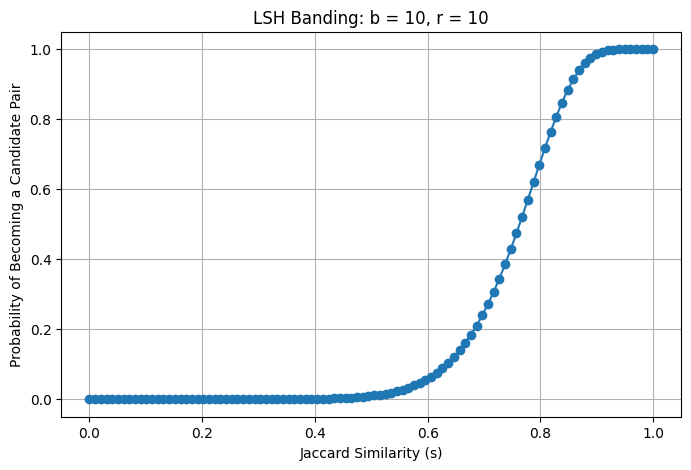

In [8]:
###############################--- step 7 Tuning Parameters ---###############################
import matplotlib.pyplot as plt
import numpy as np

def plotProbability(s_values, b, r):
    probabilities = [1 - (1 - s**r)**b for s in s_values]
    plt.figure(figsize=(8, 5))
    plt.plot(s_values, probabilities, marker='o')
    plt.xlabel('Jaccard Similarity (s)')
    plt.ylabel('Probability of Becoming a Candidate Pair')
    plt.title(f'LSH Banding: b = {b}, r = {r}')
    plt.grid(True)
    plt.show()

# Define a range of similarities and plot
s_values = np.linspace(0, 1, 100)
r = signature_matrix.shape[0] // num_bands
plotProbability(s_values, num_bands, r)

In [9]:
###############################--- step 8 Jaccard Similarity  ---###############################

import csv

def getJaccardSimilarityScore(C1, C2):
    intersection = sum(1 for x in C1 if x in C2)
    union = len(C1) + len(C2) - intersection
    return intersection / union if union > 0 else 0

similarity_threshold = 0.8 

In [ ]:
###############################--- step 9 write to csv ---###############################
# convert hash table into dictionary of article ids and its other articles that hashed in at least 1 same bucket

import pandas as pd

submission_id = []
submission_neighbors = []

with open("candidates.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # Skip header

    for doc1, doc2 in reader:
        C1 = documents_ngrams[int(doc1)]
        C2 = documents_ngrams[int(doc2)]

        score = getJaccardSimilarityScore(C1, C2)
        if score >= similarity_threshold:
            submission_id.append(doc1)
            submission_neighbors.append(doc2)

# Save results
submission_df = pd.DataFrame({
    'article_id': submission_id,
    'neighbor_id': submission_neighbors
})
submission_df.sort_values(by=['article_id'], inplace=True)
submission_df.to_csv('submissions.csv', index=False)


In [ ]:
# Remove the neighbors in same buckets but have similarity score < threshold 
import copy

n_copy = copy.deepcopy(nearest_neighbors)
submission_id = []
submission_nid = []

for article_id, neighbor_ids in n_copy.items():
    for nid in neighbor_ids:
        # Compute the Jaccard similarity between the two documents
        score = getJaccardSimilarityScore(documents_ngrams[article_id], documents_ngrams[nid])
        if score < s:
            # If the similarity is below the threshold, skip adding this pair.
            continue
        else:
            # Otherwise, add the article and its neighbor to the submission lists.
            submission_id.append(article_id)
            submission_nid.append(nid)

In [ ]:

data = pd.DataFrame()
data['article_id'] = submission_id
data['neighbor_id'] = submission_nid
data.sort_values(by=['article_id', 'neighbor_id'], inplace=True)

In [ ]:
data.head(100)